#### Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021
**<center>Лабораторная работа №4. Критерии принятия решения и метрики качества</center>**

**Цель работы:** изучение основных критериев принятия решения и метрик качества, рассматриваемых при решении задачи голосовой биометрии.						

**<center>Содержание лабораторной работы</center>**

1. Подготовка тестовых данных и протокола для проведения тестирования системы верификации диктора.							

2. Вычисление дикторских моделей для эталонных и тестовых звукозаписей используемого протокола.

3. Формирование оценок сравнения эталонных и тестовых дикторских моделей.

4. Построение таргет- и импостор-гистограмм оценок сравнения моделей.

5. Вычисление порогового значения, вероятности ошибки принятия решения, вероятностей ошибок первого и второго рода: критерий максимального правдоподобия, критерий максимума апостериорной вероятности (критерий минимума вероятности ошибки), критерий Неймана-Пирсона, критерий Байеса и минимаксный критерий.

6. Вычисление значения равновероятной ошибки (EER, Equal Error Rate).							

In [1]:
# Import of modules
from math import sqrt, pi

import numpy as np
from matplotlib.pyplot import hist, plot, show, grid, title, xlabel, ylabel, legend, axis, imshow
import torch
from torch.utils.data import DataLoader
import itertools

from dataprep import download_dataset, extract_dataset, download_protocol, load_model
from ResNetSE34V2 import MainModel
from DatasetLoader import test_dataset_loader, extract_features, compute_scores
from perf import get_eer

**<center>1. Подготовка тестовых данных и протокола для проведения тестирования системы верификации диктора</center>**

1. Выполнить загрузку и распаковку звуковых wav-файлов базы [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip).

2. Выполнить загрузку протокола тестирования [VoxCeleb1-O cleaned](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/meta/veri_test2.txt).

![Рисунок 1](./images/image1.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [5]:
# Download VoxCeleb1 (test set)
with open('./lists/datasets.txt', 'r') as f:
    lines = f.readlines()

download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='./')

In [3]:
# Extract VoxCeleb1 test set
extract_dataset(save_path='./voxceleb1_test', fname='vox1_test_wav.zip')

Extracting of vox1_test_wav.zip is successful.


In [4]:
# Download VoxCeleb1-O cleaned protocol
with open('./lists/protocols.txt', 'r') as f:
    lines = f.readlines()
    
download_protocol(lines, save_path='./voxceleb1_test')

File veri_test2.txt is downloaded.


**<center>2. Вычисление дикторских моделей для эталонных и тестовых звукозаписей используемого протокола</center>**

1. Описать и инициализировать модель для генерации дикторских эмбеддингов.

2. Вгрузить в инициализированную модель обученные веса.

3. Вычислить эмбеддинги для протокольных эталонных и тестовых звукозаписей.

In [2]:
# Model initialization
model = MainModel()

Embedding size is 512, encoder ASP.


In [3]:
# Load trained model
with open('./lists/models.txt', 'r') as f:
    lines = f.readlines()
        
model = load_model(model, lines, save_path='./models')

model = model.cuda()

File baseline_v2_ap.model is downloaded.


In [4]:
# Load test protocol
with open('./voxceleb1_test/veri_test2.txt', 'r') as f:
    lines = f.readlines()
    
# Get a list of unique file names
files = list(itertools.chain(*[x.strip().split()[-2:] for x in lines]))
setfiles = list(set(files))
setfiles.sort()

# Define test data loader
test_dataset = test_dataset_loader(setfiles, test_path='./voxceleb1_test/wav/', eval_frames=400, num_eval=10)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=10, drop_last=False, sampler=None)

# Extract features for every image
feats = extract_features(model, test_loader)

**<center>3. Формирование оценок сравнения эталонных и тестовых дикторских моделей</center>**

1. Выполнить формирование оценок сравнения эталонных и дикторских модель с использованием любой подходящей метрики (евклидово расстояние, косинусное расстояние и т.п.).

2. Сформировать списки оценок сравнения, таргет-/импостор-меток и имен эталон-тест в триальных сравнениях.

In [5]:
# Compute scores between enroll and test speaker models
all_scores, all_labels, all_trials = compute_scores(feats, lines)

**<center>4. Построение таргет- и импостор-гистограмм оценок сравнения моделей</center>**

1. Разделить оценки сравнения на два набор: таргет-сравнения и импостор-сравнения.

2. Построить гистограммы для таргет-оценок и импостор-оценок.

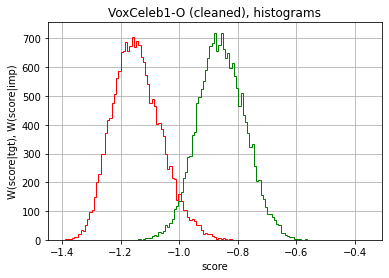

In [6]:
# Compute target and impostor histogram
tar_scores = []
imp_scores = []
for idx in range(len(all_labels)):
    
    if all_labels[idx] == 1:
        tar_scores.append(all_scores[idx])
        
    else:
        imp_scores.append(all_scores[idx])
        
tar_scores = np.array(tar_scores)
imp_scores = np.array(imp_scores)

# Plot histograms for target and impostor scores
min_scores = np.concatenate((tar_scores, imp_scores)).min()
max_scores = np.concatenate((tar_scores, imp_scores)).max()

hist(tar_scores, int(sqrt(len(tar_scores))), histtype='step', color='green', range=(min_scores, max_scores))
hist(imp_scores, int(sqrt(len(imp_scores))), histtype='step', color='red',   range=(min_scores, max_scores))
xlabel('score'); ylabel('W(score|tgt), W(score|imp)'); title('VoxCeleb1-O (cleaned), histograms'); grid(); show()

**<center>5. Вычисление порогового значения, вероятности ошибки принятия решения, вероятностей ошибок первого и второго рода</center>**

1. Вычислить логарифм отношение правдоподобия.

2. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием критерия максимального правдоподобия и критерия максимума апостериорной вероятности (критерий минимума вероятности ошибки).

3. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием критерия Неймана-Пирсона.

4. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием критерия Байеса.

5. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием минимаксного критерий.

In [7]:
# Gaussian probability density function
gauss_pdf = lambda score, mu, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(score - mu)**2/(2*(abs(sigma) + 1e-10)**2))

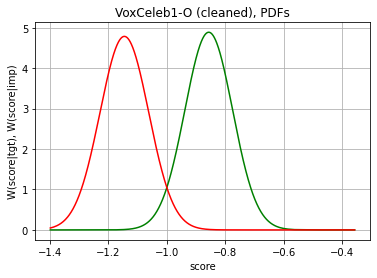

In [8]:
# Compute log-likelihood ratio
tar_scores_mean = np.mean(tar_scores)
tar_scores_std  = np.std(tar_scores)
imp_scores_mean = np.mean(imp_scores)
imp_scores_std  = np.std(imp_scores)

all_scores           = np.array(all_scores)
all_scores_sort_idxs = np.argsort(all_scores)

all_scores_sort = []
ground_truth    = []
for idx in all_scores_sort_idxs:
    all_scores_sort.append(all_scores[idx])
    ground_truth.append(all_labels[idx])

all_scores_sort = np.array(all_scores_sort)
ground_truth    = np.array(ground_truth, dtype='bool')

tar_gauss_pdf = gauss_pdf(all_scores_sort, tar_scores_mean, tar_scores_std)
imp_gauss_pdf = gauss_pdf(all_scores_sort, imp_scores_mean, imp_scores_std)
LLR           = np.log(tar_gauss_pdf/imp_gauss_pdf)

plot(all_scores_sort, tar_gauss_pdf, color='green')
plot(all_scores_sort, imp_gauss_pdf, color='red')
xlabel('score'); ylabel('W(score|tgt), W(score|imp)'); title('VoxCeleb1-O (cleaned), PDFs'); grid(); show()

In [9]:
# Maximum-likelihood test and  maximum a posteriori (MAP) test. MAP is the same as Minimum Probability of Error Test
P_Htar = 1/2 # probability of target hypothesis

len_thr = len(all_scores_sort)
fnr_thr = np.zeros(len_thr)
fpr_thr = np.zeros(len_thr)
P_err   = np.zeros(len_thr)

for idx in range(len_thr):
    solution = LLR > LLR[idx]                                      # decision
    
    err = (solution != ground_truth)                               # error vector
    
    fnr_thr[idx] = np.sum(err[ ground_truth])/len(tar_scores)      # probability of Type I  error P(Dimp|Htar), false negative ratio (FNR)
    fpr_thr[idx] = np.sum(err[~ground_truth])/len(imp_scores)      # probability of Type II error P(Dtar|Himp), false positive ratio (FPR)
    
    P_err[idx]   = fnr_thr[idx]*P_Htar + fpr_thr[idx]*(1 - P_Htar) # probability of error

P_err_idx = np.argmin(P_err) # argmin of error's probability
P_err_min = fnr_thr[P_err_idx]*P_Htar + fpr_thr[P_err_idx]*(1 - P_Htar)

print('Threshold value:      {0:.3f}'.format(LLR[P_err_idx]))
print('False negative ratio: {0:.3f}'.format(fnr_thr[P_err_idx]))
print('False positive ratio: {0:.3f}'.format(fpr_thr[P_err_idx]))
print('Probability of error: {0:.3f}'.format(P_err_min))

Threshold value:      -0.035
False negative ratio: 0.034
False positive ratio: 0.052
Probability of error: 0.043


In [10]:
# Neyman-Pearson test
P_Htar = 1/2 # probability of target hypothesis
fnr    = 1/4 # given probability of Type I error P(Dimp|Htar), false negative ratio (FNR)

len_thr = len(all_scores_sort)
fnr_thr = np.zeros(len_thr)
P_err   = np.zeros(len_thr)

for idx in range(len_thr):
    solution = LLR > LLR[idx]                                # decision
    
    err = (solution != ground_truth)                         # error vector
    
    fnr_thr[idx] = np.sum(err[ground_truth])/len(tar_scores) # probability of Type I  error P(Dimp|Htar), false negative ratio (FNR)

thr_idx  = np.argmin(np.abs(fnr_thr - fnr))           # search of threshold for a given FNR
solution = LLR > LLR[thr_idx]                         # decision
err      = (solution != ground_truth)                 # error vector
fpr      = np.sum(err[~ground_truth])/len(imp_scores) # probability of Type II error P(Dtar|Himp), false positive ratio (FPR)                   % вероятность ошибки второго рода P(D0|H1)
P_err    = fnr*P_Htar + fpr*(1 - P_Htar)              # probability of error

print('Threshold value:      {0:.3f}'.format(LLR[thr_idx]))
print('False negative ratio: {0:.3f}'.format(fnr))
print('False positive ratio: {0:.3f}'.format(fpr))
print('Probability of error: {0:.3f}'.format(P_err))

Threshold value:      3.681
False negative ratio: 0.250
False positive ratio: 0.006
Probability of error: 0.128


In [11]:
# Bayes' test
P_Htar = 1/2 # probability of target hypothesis
C00    = 0   # cost of event (Dtar, Htar)
C10    = 1   # cost of event (Dimp, Htar)
C01    = 1   # cost of event (Dtar, Himp)
C11    = 0   # cost of event (Dimp, Himp)

len_thr = len(all_scores_sort)
tpr     = np.zeros(len_thr)
fnr     = np.zeros(len_thr)
fpr     = np.zeros(len_thr)
tnr     = np.zeros(len_thr)
AC      = np.zeros(len_thr)

for idx in range(len_thr):
    solution = LLR > LLR[idx]                                        # decision
    
    ts  = (solution == ground_truth)                                 # true solution vector
    err = (solution != ground_truth)                                 # error vector
    
    tpr[idx] = np.sum(ts [ ground_truth])/len(tar_scores)            # true positive ratio (TPR)
    fnr[idx] = np.sum(err[ ground_truth])/len(tar_scores)            # probability of Type I  error P(Dimp|Htar), false negative ratio (FNR)                   % вероятность ошибки первого рода P(D1|H0)
    fpr[idx] = np.sum(err[~ground_truth])/len(imp_scores)            # probability of Type II error P(Dtar|Himp), false positive ratio (FPR)                   % вероятность ошибки второго рода P(D0|H1)
    tnr[idx] = np.sum(ts[ ~ground_truth])/len(imp_scores)            # true negative ratio (TNR)
    
    AC[idx]  = C00*tpr[idx]*P_Htar + C10*fnr[idx]*P_Htar + \
               C01*fpr[idx]*(1 - P_Htar) + C11*tnr[idx]*(1 - P_Htar) # Bayes' risk (average cost)

AC_idx    = np.argmin(AC) # argmin of Bayes' risk
P_err_min = fnr_thr[AC_idx]*P_Htar + fpr_thr[AC_idx]*(1 - P_Htar)

print('Threshold value:      {0:.3f}'.format(LLR[AC_idx]))
print('False negative ratio: {0:.3f}'.format(fnr_thr[AC_idx]))
print('False positive ratio: {0:.3f}'.format(fpr_thr[AC_idx]))
print('Probability of error: {0:.3f}'.format(P_err_min))

Threshold value:      -0.035
False negative ratio: 0.034
False positive ratio: 0.052
Probability of error: 0.043


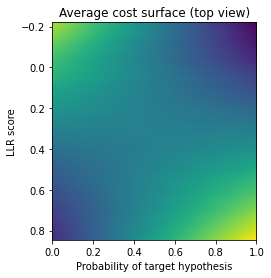

Threshold value:        -0.035
False negative ratio:   0.044
False positive ratio:   0.044
Probability of error:   0.044
Minmax of average cost: 0.044
Probability of Htar:    0.464


In [12]:
# Minimax test
P_Htar_thr = np.linspace(0, 1, num=1000) # set of probabilities of target hypothesis
C00        = 0                           # cost of event (Dtar, Htar)
C10        = 1                           # cost of event (Dimp, Htar)
C01        = 1                           # cost of event (Dtar, Himp)
C11        = 0                           # cost of event (Dimp, Himp)

len_thr        = len(all_scores_sort)
len_P_Htar_thr = len(P_Htar_thr)
tpr            = np.zeros(len_thr)
fnr            = np.zeros(len_thr)
fpr            = np.zeros(len_thr)
tnr            = np.zeros(len_thr)
AC             = np.zeros([len_thr, len_P_Htar_thr])

for idx in range(len_thr):
    solution = LLR > LLR[idx]                                        # decision
    
    ts  = (solution == ground_truth)                                 # true solution vector
    err = (solution != ground_truth)                                 # error vector
    
    tpr[idx] = np.sum(ts [ ground_truth])/len(tar_scores)            # true positive ratio (TPR)
    fnr[idx] = np.sum(err[ ground_truth])/len(tar_scores)            # probability of Type I  error P(Dimp|Htar), false negative ratio (FNR)                   % вероятность ошибки первого рода P(D1|H0)
    fpr[idx] = np.sum(err[~ground_truth])/len(imp_scores)            # probability of Type II error P(Dtar|Himp), false positive ratio (FPR)                   % вероятность ошибки второго рода P(D0|H1)
    tnr[idx] = np.sum(ts[ ~ground_truth])/len(imp_scores)            # true negative ratio (TNR)
    
    for idy in range(len_P_Htar_thr):
        AC[idx, idy] = C00*tpr[idx]*P_Htar_thr[idy] + C10*fnr[idx]*P_Htar_thr[idy] + \
                       C01*fpr[idx]*(1 - P_Htar_thr[idy]) + C11*tnr[idx]*(1 - P_Htar_thr[idy]) # Bayes' risk (average cost)
        
imshow(AC[18305:19305, :], extent=[P_Htar_thr[0], P_Htar_thr[999], LLR[19305], LLR[18305]])
xlabel('Probability of target hypothesis'); ylabel('LLR score'); title('Average cost surface (top view)');show()

AC_P_Htar_max = np.zeros(len_thr)
for idx in range(len_thr):
    AC_P_Htar_max[idx] = np.amax(AC[idx, :])

AC_min_max_idx = np.argmin(AC_P_Htar_max)

AC_thr_min = np.zeros(len_P_Htar_thr)
for idx in range(len_P_Htar_thr):
    AC_thr_min[idx] = np.amin(AC[:, idx])

AC_max_min_idx = np.argmax(AC_thr_min)
    
solution = LLR > LLR[AC_min_max_idx]                  # decision
err      = (solution != ground_truth)                 # error vector
fnr      = np.sum(err[ ground_truth])/len(tar_scores) # probability of Type I  error P(Dimp|Htar), false negative ratio (FNR)       
fpr      = np.sum(err[~ground_truth])/len(imp_scores) # probability of Type II error P(Dtar|Himp), false positive ratio (FPR)                   % вероятность ошибки второго рода P(D0|H1)
P_err    = fnr*P_Htar_thr[AC_max_min_idx] + \
           fpr*(1 - P_Htar_thr[AC_max_min_idx])       # probability of error

print('Threshold value:        {0:.3f}'.format(LLR[AC_idx]))
print('False negative ratio:   {0:.3f}'.format(fnr))
print('False positive ratio:   {0:.3f}'.format(fpr))
print('Probability of error:   {0:.3f}'.format(P_err))
print('Minmax of average cost: {0:.3f}'.format(AC[AC_min_max_idx, AC_max_min_idx]))
print('Probability of Htar:    {0:.3f}'.format(P_Htar_thr[AC_max_min_idx]))

**<center>7. Вычисление значения равновероятной ошибки</center>**

Вычислить величину равновероятной ошибки для рассматриваемого протокола тестирования VoxCeleb1-O (cleaned)

In [13]:
# Compute Equal Error Rate
EER, _, _, _ = get_eer(tar_scores, imp_scores)

print('Equal Error Rate (EER): {0:.3f}%'.format(EER))

Equal Error Rate (EER): 4.376%


**<center>8. Список литературы</center>**

1. Hsu H.P. Schaum’s Ouline of Analog and Digital Communications. McGraw-Hill, 2003 ([ссылка](http://www.oasitech.it/upl/ese_schaum.pdf)).

2. Hsu H.P. Schaum’s Ouline of Theory and Problems of Probability, Random Variables, and Random Processes. McGraw-Hill, 1997 ([ссылка](http://webpages.iust.ac.ir/matashbar/teaching/schaum_probability.pdf)).